In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_fscore_support, roc_auc_score, RocCurveDisplay,
    PrecisionRecallDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
RANDOM_STATE = 42
pd.set_option('display.max_columns', 200)

In [2]:
df = pd.read_csv("loan_approval_dataset.csv")
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [3]:
df.shape

(4269, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [5]:
df.isnull().sum()

,0
loan_id,0
no_of_dependents,0
education,0
self_employed,0
income_annum,0
loan_amount,0
loan_term,0
cibil_score,0
residential_assets_value,0
commercial_assets_value,0


In [6]:
df.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [7]:
df=df.rename(columns={" loan_status": "loan_status"})

In [8]:
print(df['loan_status'].unique())

[' Approved' ' Rejected']


In [9]:
df['loan_status'] = df['loan_status'].str.strip().str.lower()
print(df['loan_status'].unique())

['approved' 'rejected']


In [12]:
if 'loan_id' in df.columns:
    df = df.drop(columns=['loan_id'])

df.columns = df.columns.str.strip()

if df['loan_status'].dtype == 'O':
    df['loan_status'] = df['loan_status'].map({'approved':1, 'rejected':0})
print(df['loan_status'].unique())
y = df['loan_status']
X = df.drop(columns=['loan_status'])

[1 0]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(loan_status
 1    0.622255
 0    0.377745
 Name: proportion, dtype: float64,
 loan_status
 1    0.62178
 0    0.37822
 Name: proportion, dtype: float64)

In [14]:
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object','category','bool']).columns.tolist()
numeric_cols, categorical_cols

(['no_of_dependents',
  'income_annum',
  'loan_amount',
  'loan_term',
  'cibil_score',
  'residential_assets_value',
  'commercial_assets_value',
  'luxury_assets_value',
  'bank_asset_value'],
 ['education', 'self_employed'])

In [15]:
numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))])

categorical_tf = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, numeric_cols),
        ("cat", categorical_tf, categorical_cols)
    ]
)


In [16]:
logreg_clw = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))
])

tree_clw = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE))
])

logreg_clw.fit(X_train, y_train)
tree_clw.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['no_of_dependents',
                                                   'income_annum',
                                                   'loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'residential_assets_value',
                                                   'commercial_assets_value',
                                                   'luxury_assets_value',
                                                   'bank_asset_value']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['education',
                                                   'self_employed'])])),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])


=== LogReg (class_weight) ===
              precision    recall  f1-score   support

           0      0.742     0.712     0.727       323
           1      0.829     0.849     0.839       531

    accuracy                          0.797       854
   macro avg      0.785     0.781     0.783       854
weighted avg      0.796     0.797     0.797       854



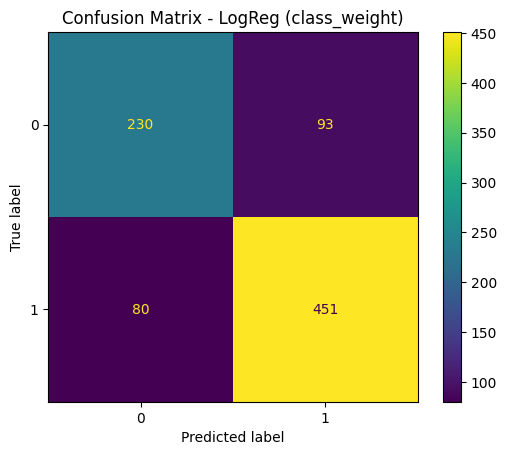

ROC-AUC: 0.865


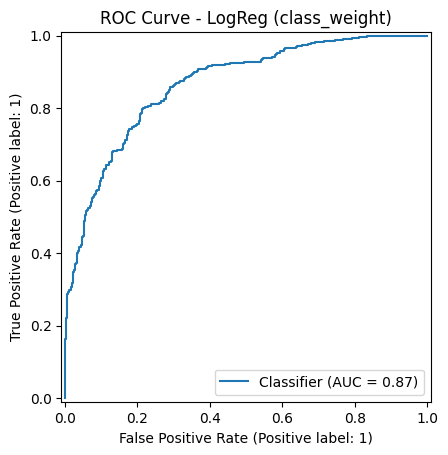

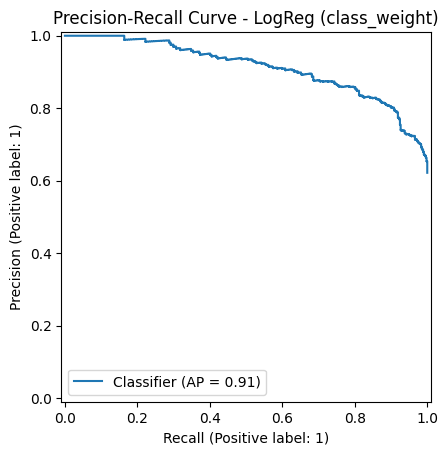


=== DecisionTree (class_weight) ===
              precision    recall  f1-score   support

           0      0.978     0.963     0.970       323
           1      0.978     0.987     0.982       531

    accuracy                          0.978       854
   macro avg      0.978     0.975     0.976       854
weighted avg      0.978     0.978     0.978       854



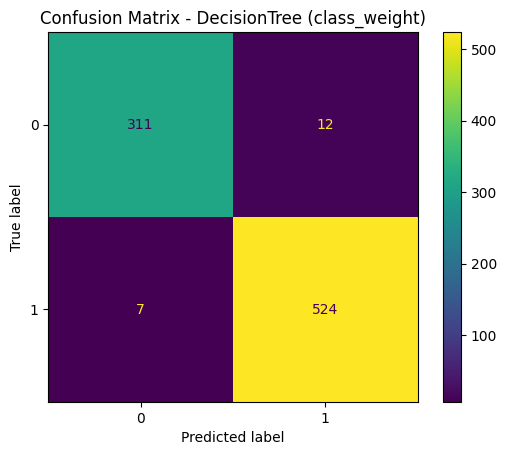

ROC-AUC: 0.975


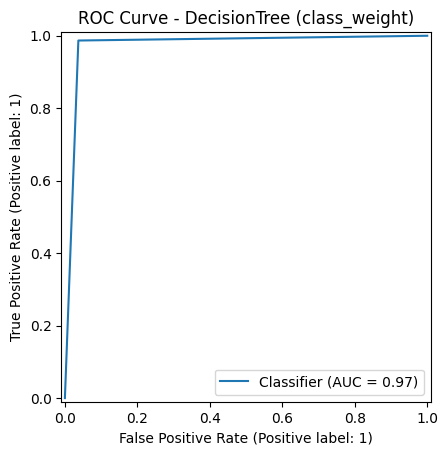

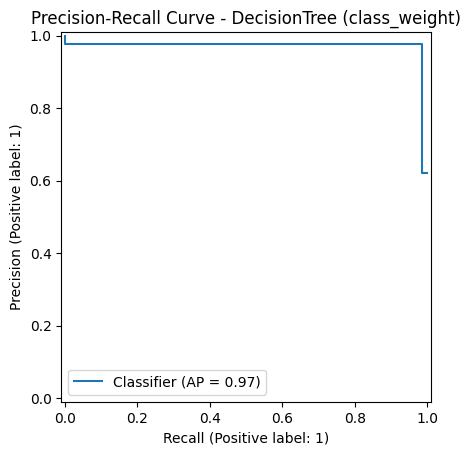

In [18]:
def evaluate(model, X_tr, y_tr, X_te, y_te, name="Model"):
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_te)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
    print(classification_report(y_te, y_pred, digits=3))

    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_te, y_proba)
            print(f"ROC-AUC: {auc:.3f}")
            RocCurveDisplay.from_predictions(y_te, y_proba)
            plt.title(f"ROC Curve - {name}")
            plt.show()
        except Exception as e:
            print("ROC-AUC not available:", e)
    if y_proba is not None:
        PrecisionRecallDisplay.from_predictions(y_te, y_proba)
        plt.title(f"Precision-Recall Curve - {name}")
        plt.show()

evaluate(logreg_clw, X_train, y_train, X_test, y_test, "LogReg (class_weight)")
evaluate(tree_clw, X_train, y_train, X_test, y_test, "DecisionTree (class_weight)")


Bonus


=== LogReg + SMOTE ===
              precision    recall  f1-score   support

           0      0.744     0.728     0.736       323
           1      0.836     0.847     0.842       531

    accuracy                          0.802       854
   macro avg      0.790     0.788     0.789       854
weighted avg      0.801     0.802     0.802       854



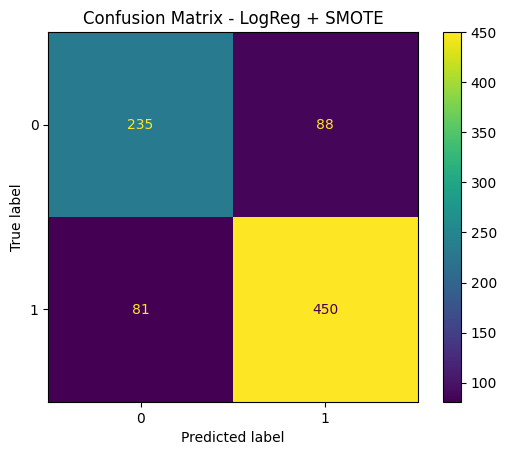

ROC-AUC: 0.882


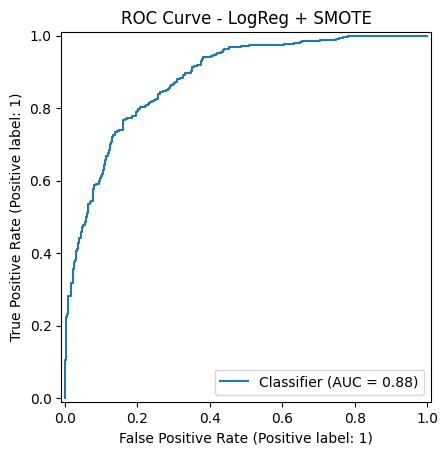

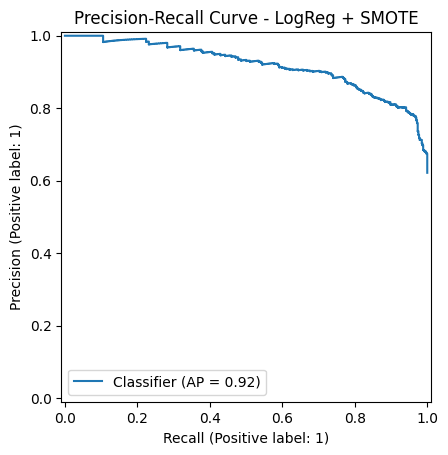


=== DecisionTree + SMOTE ===
              precision    recall  f1-score   support

           0      0.975     0.972     0.974       323
           1      0.983     0.985     0.984       531

    accuracy                          0.980       854
   macro avg      0.979     0.979     0.979       854
weighted avg      0.980     0.980     0.980       854



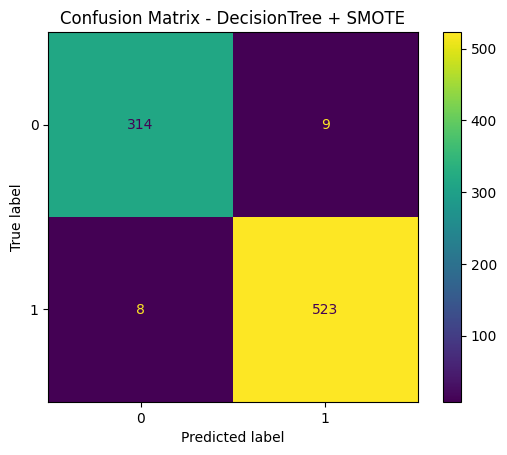

ROC-AUC: 0.979


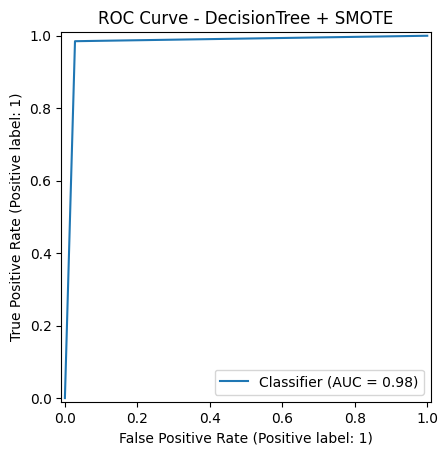

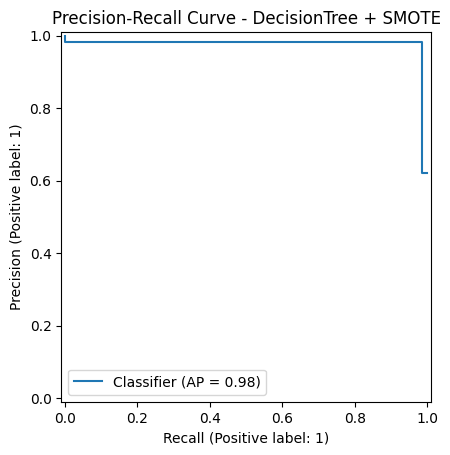

In [19]:
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)

logreg_smote = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", smote),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

tree_smote = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", smote),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

logreg_smote.fit(X_train, y_train)
tree_smote.fit(X_train, y_train)

evaluate(logreg_smote, X_train, y_train, X_test, y_test, "LogReg + SMOTE")
evaluate(tree_smote, X_train, y_train, X_test, y_test, "DecisionTree + SMOTE")


In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cv_score(pipe, X_tr, y_tr, scoring='f1'):
    scores = cross_val_score(pipe, X_tr, y_tr, scoring=scoring, cv=cv, n_jobs=-1)
    return scores.mean(), scores.std()

for name, model in {
    "LogReg (clw)": logreg_clw,
    "Tree (clw)": tree_clw,
    "LogReg + SMOTE": logreg_smote,
    "Tree + SMOTE": tree_smote
}.items():
    mean_f1, std_f1 = cv_score(model, X_train, y_train, scoring='f1')
    print(f"{name}: CV F1 = {mean_f1:.3f} ± {std_f1:.3f}")


LogReg (clw): CV F1 = 0.830 ± 0.010
Tree (clw): CV F1 = 0.978 ± 0.005
LogReg + SMOTE: CV F1 = 0.831 ± 0.010
Tree + SMOTE: CV F1 = 0.979 ± 0.006


In [21]:
from sklearn.metrics import precision_recall_curve

best = None
y_proba = logreg_smote.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-9)
idx = np.nanargmax(f1s)
best = {"threshold": thr[idx] if idx < len(thr) else 0.5,
        "precision": float(prec[idx]),
        "recall": float(rec[idx]),
        "f1": float(f1s[idx])}
best


{'threshold': np.float64(0.33270072555020813),
 'precision': 0.8025682182985554,
 'recall': 0.9416195856873822,
 'f1': 0.8665511260196423}

              precision    recall  f1-score   support

           0      0.866     0.619     0.722       323
           1      0.803     0.942     0.867       531

    accuracy                          0.820       854
   macro avg      0.834     0.780     0.794       854
weighted avg      0.826     0.820     0.812       854



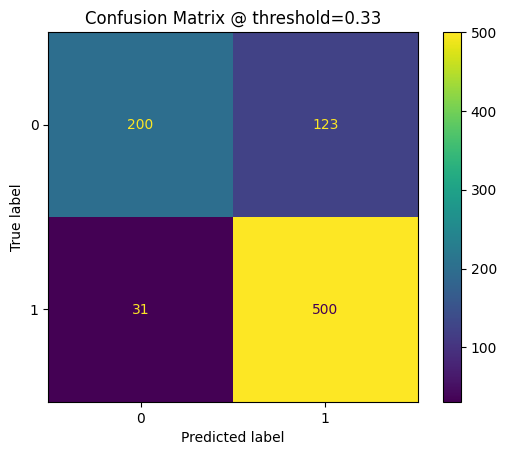

In [22]:
thr_star = best["threshold"]
y_pred_thr = (y_proba >= thr_star).astype(int)
print(classification_report(y_test, y_pred_thr, digits=3))
cm = confusion_matrix(y_test, y_pred_thr)
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix @ threshold={thr_star:.2f}")
plt.show()
